# NOTE: Based on Barth+2020 (and Ribas+2014), offset chosen as 5 Myr -- end of planet formation, beginning of MO phase

In [1]:
%pylab inline
import math
import numpy as np
import scipy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as ticker
from matplotlib.font_manager import FontProperties
from pylab import *
from scipy.integrate import ode
#from mpl_toolkits.axes_grid.inset_locator import inset_axes
import time
import os.path

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Need to divide constants into three categories --
# XXXX SEE OTHER RECODED NOTEBOOK FOR DESCRIPTIONS OF ALL CONSTANTS XXXX

# 1) Unchanging constants
# [M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry]

params1 = np.loadtxt('const_params.txt')
##### FOR MAGMA OCEAN ######
rho_MO = 3.0e3
############################
M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1

# 2) Varied parameters
# [x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
#  T_serp, K_cnst, gamma, r_fug, d_b]

params2 = np.loadtxt('vary_params.txt')
##### FOR MAGMA OCEAN ######
alpha_MO = 5.0e-5
k_MO = 4.
c_p_MO = 1000.
kappa_MO = k_MO/(rho_MO*c_p_MO)
############################
x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
     T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
# Test different betas; see if the code breaks
#beta = 0.12
#params2[11] = beta

# 3) Changing parameters
# [omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt]

params3 = np.loadtxt('change_params.txt')
omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt_nom = params3
dt_nom = 2.0e4*year
params3[8] = dt_nom

# NEW constants, for 1-D atmosphere calculations
sigma_sb = 5.67e-8 #[W/m^2/K^4]; Stefan-Boltzmann constant
m_H = 1.66e-27 #[kg]; mass of H atom
k_B = 1.38e-23 #[m^2 kg s^-2 K^-1]; Boltzmann constant
m_H2O = 18.02*m_H #molecular mass of water
m_air = 28.7*m_H #molecular mass of air on Earth
rho_water = 997. #[kg/m^3]; density of water
cp_water_vapour = 1.996e3 #[J/(kg K)]; specific heat capacity of water vapour (steam)

In [3]:
print(year)

31540000.0


In [4]:
# Parameters of orbiting planet (can be changed later).
a_orb = 0.06727532*1.496e11 #[m], middle of HZ around Proxima Cen (calculated from Kopparapu+2013)
alb = 0.3 #albedo; value roughly similar to Earth
#alb = 0.75 #albedo; upper limit to roughly test "steam atmosphere"

## Required thermal evolution equations

In [5]:
## WATER FUGACITY
# Need to calculate non-dimensional water fugacity at each step.
# Formula original from Li et al. (2008), based on experimental data.
def lnf_w(x, params1, params2, params3): #NOTE: Takes non-dimensionalized mantle water mass fraction and converts it.
    c0 = -7.9859
    c1 = 4.3559
    c2 = -0.5742
    c3 = 0.0337
    B = 2.0e6
    mu_oliv = 153.31
    mu_wat = 18.01528
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt_nom = params3
    
    ln_term = np.log((B*x*(mu_oliv/mu_wat))/(1.-(x*(mu_oliv/mu_wat))))
    
    return c0 + c1*ln_term + c2*ln_term**2. + c3*ln_term**3.

def f_w(x, params1, params2, params3):
    
    return np.exp(lnf_w(x, params1, params2, params3))

In [6]:
# Melt fraction -- to be checked to determine if thermal evolution is liquid or solid-like
def f_melt(t, temp, W_m, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt_nom = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    x = W_m/(f_M*M)
    
    return ((temp-(T_sol_dry-K_cnst*x**gamma))/(T_liq_dry-T_sol_dry))**theta

In [7]:
## MANTLE VISCOSITY

# SOLID MANTLE VISCOSITY (Schaefer & Sasselov 2015)
# Need a function to calculate the viscosity.
def eta(temp, x, params1, params2, params3): #x and T are non-dimensionalized later in code -- need to add dimensions back for these calculations
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt_nom = params3
    
    eta_scale = (np.exp(lnf_w(5.8e-4,params1,params2,params3)))**(-r_fug)
    eta_0 = 1.0e21/eta_scale
        
    # Need a minimum fugacity, to avoid f_w --> 0 and eta --> infinity.
    # Let's take the 'desiccation limit' for the surface as the minimum value to be 'trapped' in the mantle.
    if x <= 1.29e16/(f_M*M_E):
        return eta_0*(f_w(1.29e16/(f_M*M_E), params1, params2, params3)**(-r_fug)) * np.exp((E_a/R_g)*((1./temp) - (1./T_ref)))
    else:
        return eta_0*(f_w(x, params1, params2, params3)**(-r_fug)) * np.exp((E_a/R_g)*((1./temp) - (1./T_ref)))
    
    #if f_w(x, params1, params2, params3) > f_w_min:
    #    return eta_0 * (f_w(x, params1, params2, params3)**(-r_fug)) * np.exp((E_a/R_g)*((1./temp) - (1./T_ref)))
    #elif f_w(x, params1, params2, params3) <= f_w_min:
    #    return eta_0 * (f_w_min**(-r_fug)) * np.exp((E_a/R_g)*((1./temp) - (1./T_ref)))
    
# MAGMA OCEAN VISCOSITY (Lebrun et al. 2013)
def eta_MO(t, temp, x, params1, params2, params3):
    
    W_m = x*(f_M*M)
    
    f_melt_crit = 0.4
    
    eta_l = 0.00024*np.exp(4600./(temp-1000.))
    
    #return eta_l/((1.-((1-f_melt(t, temp, W_m, M, params1, params2, params3, params4))/(1.-f_melt_crit)))**2.5)
    
    # From ChEd: Just use a constant value for now; test range from 0.1 Pa s - 1000 Pa s
    return 1. #[Pa s]

In [8]:
def Rp(M):
    M_E = 5.972e24
    R_E = 6.371e6
    return R_E*(M/M_E)**0.27

def Rc(M):
    M_E = 5.972e24
    R_E = 6.371e6
    return 0.547*R_E*(M/M_E)**0.25

def h(M):
    return Rp(M) - Rc(M)

def g(M):
    G = 6.67e-11
    return G*M/(Rp(M)**2.)

def A(M):
    return 4.*np.pi*(Rp(M)**2.)

def V(M):
    return (4.*np.pi/3.)*((Rp(M)**3.) - (Rc(M)**3.))

def F_0(M, params1, params2, params3):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt_nom = params3
    
    eta_scale = (np.exp(lnf_w(1.,params1,params2,params3)))**(-r_fug)
    eta_0 = 1.e21/eta_scale

    f_w = np.exp(lnf_w(5.8e-4,params1,params2,params3))
    return (k*(T_ref**(1.+beta))*A(M)/(h(M)*V(M)))*(alpha*rho_m*g(M)*(h(M)**3.)*f_w/(Ra_c*kappa*eta_0))**beta

def L_MOR(M):
    return 1.5*2.*np.pi*Rp(M)

def S(t, temp, x, T_surf, M, params1, params2, params3):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt_nom = params3
    
    return 10.76*(kappa**(1.-2.*beta))*(h(M)**(6.*beta-1.))*((alpha*rho_m*g(M)*\
            (temp-T_surf)/(eta(temp,x,params1,params2,params3)*Ra_c))**(2.*beta))

def tau(M, params1, params2, params3): #useful for converting between different non-dimensional timescales
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt_nom = params3
    
    return (L_MOR(M)*(0.1/year)*x_h*rho_c*chi*d_hE)/(M*omega_0*f_btwid) #spreading rate independent of temp in this model

def Ra(t, temp, x, T_surf, M, params1, params2, params3):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt_nom = params3
    
    return (alpha*rho_m*g(M)*(temp - T_surf)*(h(M)**3))/(eta(temp, x, params1, params2, params3)*kappa)

# Nusselt number, for looking at heat flux
def Nu(temp, x, T_surf, M, params1, params2, params3):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt_nom = params3
    
    return (Ra(t, temp, x, T_surf, M, params1, params2, params3)/Ra_c)**beta

In [9]:
P_0_star = 1.4e11 #[Pa]
l_c_NJ = 43655 #[J/mol] THIS VALUE IS USED BY NAKAJIMA+ 1992
l_c = 2441.7e3 # [J/kg] (https://www.engineeringtoolbox.com/water-properties-d_1573.html)
R_gas_NJ = 8.314 #[J/mol/K] THIS VALUE IS USED BY NAKAJIMA+ 1992
R_gas = 8314. #[J/kg/K]

# Saturation water vapour pressure
def P_star(T): 
    
    return P_0_star*np.exp(-l_c_NJ/(R_gas_NJ*T))

# Seafloor pressure
def P(s, M, T_surf, params1, params2, params3):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt_nom = params3
    
    # Subtract mass of overlying atmosphere from surface water.
    M_ocean = (s*M) - ((P_star(T_surf)/g(M))*4.*np.pi*(Rp(M)**2))
    
    # Return just the seafloor pressure.
    return M_ocean*g(M)/(f_b*4.*np.pi*(Rp(M)**2))

# T-dependent hydration depth
def d_h(t, temp, T_surf, x, M, params1, params2, params3):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt_nom = params3
    
    return (h(M)**(1.0-3.0*beta))*((temp-T_surf)**(-(1.0+beta)))*\
        (T_serp-T_surf)*((eta(temp,x,params1,params2,params3)*kappa*Ra_c/(alpha*rho_m*g(M)))**beta)

# Radionuclide heating, using 4 common Earth mantle species (i.e., nominal bulk silicate Earth, 21 ppb U)
# (Schaefer & Sasselov 2015, Eqn. (4), with constants as given in Laura's MATLAB code (see refs there))
def Q_sum(t, M, params1, params2, params3):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt_nom = params3
    
    # Mantle concentration of element by mass (Schubert et al. 2001, Ch. 4)
    Uran = 21e-9; #[U] = 21 ppb
    C_238U = 0.9927 * Uran;
    C_235U = 0.0072 * Uran;
    C_40K = 1.28 * Uran;
    C_232Th = 4.01 * Uran;
    
    # Heat production per unit mass (Schubert et al. 2001, Ch. 4)
    H_238U = 9.37e-5;
    H_235U = 5.69e-4;
    H_40K = 2.79e-5;
    H_232Th = 2.69e-5;
    
    # Decay constants
    lam_238U = 0.155e-9;
    lam_235U = 0.985e-9;
    lam_40K = 0.555e-9;
    lam_232Th = 0.0495e-9;F
    
    return rho_m*(C_238U*H_238U*np.exp(lam_238U*(4.6e9-t)) + C_235U*H_235U*np.exp(lam_235U*(4.6e9-t)) + \
            C_232Th*H_232Th*np.exp(lam_232Th*(4.6e9-t)) + C_40K*H_40K*np.exp(lam_40K*(4.6e9-t)))

In [10]:
# Things that need to be calculated with constants and above functions:
# NOTE: If dimensions are being used anyway, many of these are redundant/won't be used in the code.
omg_Etwid = num_oceans*omega_E/omega_0
omegatwid = omg_Etwid/(f_btwid)
T_stwid = T_s/T_ref
T_mtwid = T_ref*R_g/E_a
T_liqtwid = T_liq_dry/T_ref
T_soltwid = T_sol_dry/T_ref
Ktwid = K_cnst/T_ref
Xtwid = x_h*rho_c*chi*d_hE*f_M/(rho_m*d_melt*f_degasE*omega_0*f_btwid)
Pi = (rho_m*d_melt*chi_d*(omega_0*f_btwid/f_M)*((T_liqtwid-T_soltwid)**-theta))
lambdatwid = Ktwid*(omega_0*f_btwid/f_M)**(gamma)
eta_scale = (np.exp(lnf_w(5.8e-4,params1,params2,params3)))**(-r_fug)
eta_0 = 1.0e21/eta_scale
#f_w = np.exp(lnf_w(1.,params1,params2,params3))
f_wtwid_min = 1.0e-5 #CONSERVATIVELY CHOSEN FOR NOW
E = rho_m*d_melt*f_degasE*omega_0*f_btwid/f_M
#tau_heat = Q_0/(rho_m*c_p*T_ref)

# 4) Calculated parameters
params4 = [omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E]

# Instellation & atmospheric loss

In [11]:
# Stellar evolution and surface temperature calculations

# Stellar evolution track for 0.13 Msun star (similar to Proxima Cen), from Baraffe+ 2015
# Read in stellar evolution track data
data = np.loadtxt('BHAC15_0.13Msun.txt', skiprows=3)
#data = np.loadtxt('BHAC15_0.3Msun.txt', skiprows=3)
log_age = data[:,1] #log(yr)
T_eff = data[:,2] #[K]
Lbol_Ls = data[:,3] #log luminosity
R_Rs = data[:,5]

Ls = 3.839e33 # [erg/s]; solar bolometric luminosity
Lbol = np.zeros(len(Lbol_Ls))
for idx in range(0,len(Lbol_Ls)):    
    Lbol[idx] = (10.**Lbol_Ls[idx])*Ls/1.0e7 #[W]
    
Rs = 6.96e10 #[cm]; solar radius
Rstar = (R_Rs*Rs)/100.0 #[m]

star_age = np.zeros(len(log_age)) #[s], for later calculations

# Convert stellar age to time, in seconds.
for idx in range(0,len(log_age)):
    star_age[idx] = ((10.0**log_age[idx])*year)
    
print('Stellar age: ', star_age[0]/year, 'years')
#print(star_age[0])
    
# Calculate the top-of-atmosphere bolometric flux, from BHAC15 model.
def S_0(t, M, a_orb, params1, params2, params3):
        
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt_nom = params3
    
    t_int = t + (5.0e6*year) #add offset of 5 Myr, to account for formation
    
    return np.interp(t_int, star_age, Lbol)/(4.*np.pi*(a_orb**2.))
    
# Calculate evolution of XUV luminosity (Luger & Barnes 2015; Ribas+ 2005)
def L_XUV(t, M, params1, params2, params3):
        
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt_nom = params3
    
    t_int = t + (5.0e6*year) #add offset of 5 Myr, to account for formation
  
    f_sat = 1.0e-3 #saturation fraction
    t_sat = 1.0e9*year #[s], saturation timescale, XXXX SHOULD VARY THIS WHEN TESTING, BASED ON RECENT PAPERS!!! XXXX
    beta_XUV = -1.23
    
    if t <= t_sat:
        return f_sat*np.interp(t_int, star_age, Lbol)
    else: #t > t_sat
        return f_sat*((t_int/t_sat)**beta_XUV)*np.interp(t_int, star_age, Lbol)

# Calculate top-of-atmosphere XUV flux. 
def F_XUV(t, M, a_orb, params1, params2, params3):
        
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt_nom = params3
        
    return L_XUV(t, M, params1, params2, params3)/(4.*np.pi*(a_orb**2.))

# Calculate the effective temperature of the planet.
def f_T_eff(t, M, a_orb, params1, params2, params3):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt_nom = params3
    
    return ((S_0(t, M, a_orb, params1, params2, params3)*(1.0-alb))/(4.0*sigma_sb))**(0.25)

# Calculate the skin temperature (i.e., the isothermal stratosphere temperature). [K]
def T_strat(t, M, a_orb, params1, params2, params3):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt_nom = params3
    
    return ((1./2.)**0.25)*((S_0(t, M, a_orb, params1, params2, params3)*(1.0-alb))/(4.0*sigma_sb))**(0.25)

Stellar age:  504322.1001372358 years


In [12]:
# Use Goldblatt provided data, to reproduce Fig. 2b of Goldblatt+2013, for the Earth, to calculate T_surf 
#given OLR when incoming flux is below  the Simpson-Nakajima limit.
data = np.loadtxt('Goldblatt_Tsurf_OLR.txt')
T_surf_gb = data[:,0] # [K]
OLR_gb = data[:,1] #[K] 

#plt.plot(T_surf_gb, OLR_gb)

def T_surf_OLR(t, M, alb, a_orb, params1, params2, params3):
    
    if S_0(t, M, a_orb, params1, params2, params3)/4. > (282./(1.-alb)): #runaway greenhouse
                
        return 1800. #~maximum T_surf corresponding to given OLR
    
    else: #not in runaway greenhouse
        
        # Set OLR = absorbed flux
        OLR = (S_0(t, M, a_orb, params1, params2, params3)/4.)*(1.-alb)
        
        # Do a very simple linear extrapolation FOR NOW.
        z = np.polyfit(T_surf_gb[0:4], OLR_gb[0:4], 1)

        if OLR <= np.min(OLR_gb): #arbitrary lower limit
            
            return np.min(T_surf_gb) + ((OLR - np.min(OLR_gb))/z[0])
        
        else:
            
            return np.interp(OLR, OLR_gb, T_surf_gb)

In [13]:
# Function to determine total mass of water in atmosphere, given T_surf, surface water inventory, albedo.
def f_M_H2O(t, W_s, T_surf, alb, M, m, a_orb, params1, params2, params3):
    
    # Runaway greenhouse limit; divide by 4 because planet is a sphere
    # All surface water in atmosphere
    if S_0(t, M, a_orb, params1, params2, params3)/4. > (282./(1.-alb)):
        
        return W_s #[kg]
        
    else:
        
        return (P_star(T_surf)/g(M))*4.*np.pi*(Rp(M)**2.) #[kg]
    
def f_P_surf(t, W_s, T_surf, alb, M, m, a_orb, params1, params2, params3):
    
    # Runaway greenhouse limit; divide by 4 because planet is a sphere
    # All surface water in atmosphere
    if S_0(t, M, a_orb, params1, params2, params3)/4. > (282./(1.-alb)):
        
        return W_s*g(M)/(4.*np.pi*(Rp(M)**2.))
    
    else:
        
        return P_star(T_surf)

In [14]:
# Energy-limited escape rate
def loss_rate_EL(t, F_XUV, R_XUV, M): #[kg/s]
    
    # R_XUV = XUV deposition radius; LB15 set R_XUV = R_p for simplicity
    # M = planetary mass
    
    G = 6.67e-11
    eps_XUV = 0.1 #nominal; LB15 test 0.15-0.30
    
    return eps_XUV*np.pi*F_XUV*Rp(M)*(R_XUV**2.)/(G*M)

# Timescale of runaway greenhouse/magma ocean phase

In [15]:
def tau_RG(M, a_orb, alb, params1, params2, params3):
    
    dt = 2.0e4*year #20,000 yr per timestep
    t0 = 0.
      
    t = t0
    while S_0(t, M, a_orb, params1, params2, params3)/4. > (282./(1.-alb)): #runaway greenhouse
        
        t += dt
        
    return t

In [16]:
test = tau_RG(M_E, a_orb, alb, params1, params2, params3)

In [17]:
print('tau_RG = ', test/year/1.0e6, 'Myr')

tau_RG =  55.62 Myr


# Shrinking of magma ocean depth with time + growth of solid mantle

In [18]:
# Based on Fig. 3 of Barth+2020, Fig. 4 of Schaefer+2016
def d_MO(t, M, a_orb, params1, params2, params3): 
    
    d_MO_0 = h(M) # ENTIRE MANTLE BEGINS MOLTEN ##2000.0e3 #[m]
    beta_MO = 1./(np.exp(1.)-1)
    
    # TEST MULTIPLE TIMESCALES FOR NOMINAL MODEL -- 10, 50, 100 Myr (50 Myr as nominal)
    tau_MO = 50.0e6*year #conservatively chosen estimate, for mid-HZ, from Barth+2020 Fig. 5
    # XXXXX MO TIMESCALE SHOULD DEPEND ON INITIAL WATER INVENTORY + ORBITAL DISTANCE (~XUV flux)!!!!
    
#    return d_MO_0*np.exp((-t + tau_RG(M, a_orb, alb, params1, params2, params3))/(tau_RG(M, a_orb, alb, params1, params2, params3))) - d_MO_0
#    return (beta_MO*d_MO_0)*np.exp((-t/tau_RG(M, a_orb, alb, params1, params2, params3)) + 1.) - (beta_MO*d_MO_0)
#    return (beta_MO*d_MO_0)*(np.exp((-t/tau_RG(M, a_orb, alb, params1, params2, params3)) + 1.) - 1)
    return (beta_MO*d_MO_0)*(np.exp((-t/tau_MO) + 1.) - 1)

# Temperature of MO as a function of MO depth, using liquidus temperature (Eqn. 1 of Elkins-Tanton 2008)
def T_MO(t, M, a_orb, params1, params2, params3):
    
    r = (Rp(M) - d_MO(t, M, a_orb, params1, params2, params3))/1000. #[km]
    
    return (-1.16e-7*(r**3.)) + (0.0014*(r**2.)) - (6.382*r) + 1.444e4

def T_sol(r):
    
    return (-1.16e-7*(r**3.)) + (0.0014*(r**2.)) - (6.382*r) + 1.444e4

In [19]:
r_array = np.arange(3000., 6400., 50.)
T_sol_array = T_sol(r_array)

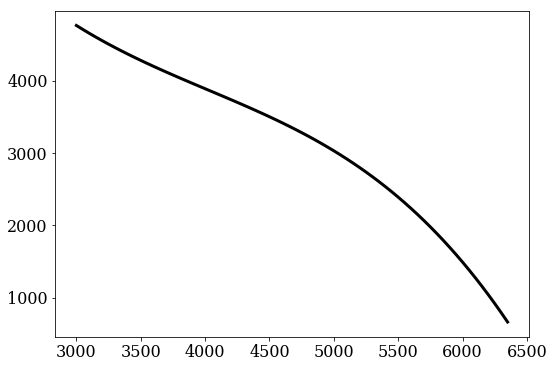

In [20]:
%matplotlib inline

plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(8.5,6))
plt.tight_layout()

plt.plot(r_array, T_sol_array, linewidth=3, color='k')

## Thermal evolution of mantle/magma ocean
## WITH VARIABLES UPDATED (see early cells) FOR MAGMA OCEAN

In [21]:
# Thermal evolution, dependent on melt fraction

def f_delta_temp(t, temp, W_m, T_surf, a_orb, M, params1, params2, params3, params4):
    
    # Silicate melt-specific variables taken from Hamano+2013
      
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt_nom = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    x = W_m/(f_M*M)
#    s = W_s/M
    
    if f_melt(t, temp, W_m, M, params1, params2, params3, params4) >= 0.4: #liquid MO convection
        
        F_MO = (0.089*k_MO*(temp-T_surf)/d_MO(t, M, a_orb, params1, params2, params3))*\
            (alpha_MO*g(M)*(temp-T_surf)*(d_MO(t, M, a_orb, params1, params2, params3)**3.)*\
             rho_MO/(eta_MO(t, temp, x, params1, params2, params3)*kappa_MO))**(1./3.)
        
        return (1./(rho_MO*c_p_MO))*(-4.*np.pi*(Rp(M)**2.))/((4.*np.pi)*((Rp(M)**2.) - (Rc(M)**2.))*d_MO(t, M, a_orb, params1, params2, params3))\
            *(F_MO - S_0(t, M, a_orb, params1, params2, params3))
    
    else: #f_melt < 0.4; solid-like convection
    
        F_MP = (k*(temp-T_surf)/h(M))*0.2*(alpha*g(M)*(temp-T_surf)*(h(M)**3.)*rho_m/\
                eta(temp, x, params1, params2, params3)*kappa)**(1./3.)

        return (1./(rho_m*c_p))*(Q_sum(t, M, params1, params2, params3)-((4.*np.pi*(Rp(M)**2.))/((4.*np.pi)*((Rp(M)**2.) - (Rc(M)**2.))*h(M))\
            *(F_MP - S_0(t, M, a_orb, params1, params2, params3))))

In [22]:
#t_array = np.linspace(0., 1.0e8*year, 5001)
dt = 2.0e4*year #20,000 yr per timestep
t_array = np.arange(0., 50.0e6*year, dt)
d_MO_array = d_MO(t_array, M_E, a_orb, params1, params2, params3)

In [23]:
r_test = Rp(M_E) - d_MO_array

In [24]:
print(r_test/1000.)

[3484.937      3486.76290857 3488.58808692 ... 6368.98324446 6369.65576523
 6370.32801704]


In [25]:
print(len(t_array))

2500


(0.0, 55620000.0)

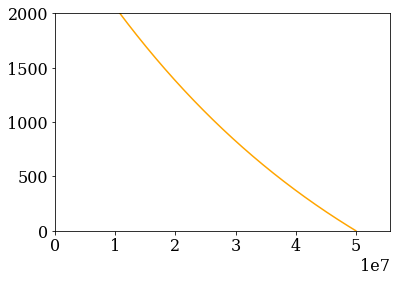

In [26]:
plt.plot(t_array/year, d_MO_array/1000., color='orange')
#plt.axvline(x=tau_RG(M_E, a_orb, alb, params1, params2, params3)/year, color='k')
#plt.axhline(y=0., color='k')
plt.ylim([0., 2000.])
plt.xlim([0., tau_RG(M_E, a_orb, alb, params1, params2, params3)/year])

In [27]:
print(d_MO_array[0]/1000.)

2886.0629999999996


In [28]:
def d_SM(t, M, a_orb, params1, params2, params3):
    
    return h(M) - d_MO(t, M, a_orb, params1, params2, params3)

In [29]:
print(d_MO(0, M_E, a_orb, params1, params2, params3)/1000., 'km')
print(d_SM(0, M_E, a_orb, params1, params2, params3)/1000., 'km')
print(h(M_E)/1000., 'km')
print(Rp(M_E)/1000., 'km')

2886.0629999999996 km
0.0 km
2886.0629999999996 km
6371.0 km


In [30]:
d_SM_array = d_SM(t_array, M_E, a_orb, params1, params2, params3)

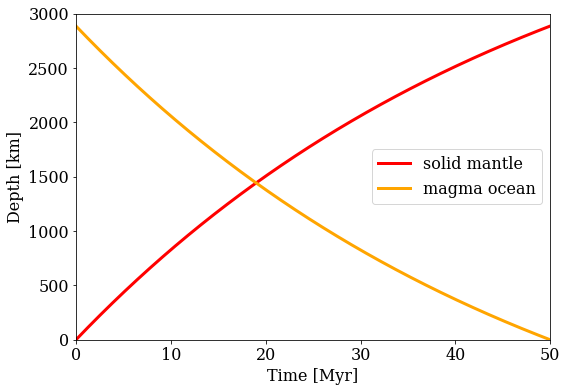

In [31]:
%matplotlib inline

plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(8.5,6))
plt.tight_layout()

plt.plot(t_array/year/1.0e6, d_SM_array/1000., color='r', linewidth=3, label='solid mantle')
plt.plot(t_array/year/1.0e6, d_MO_array/1000., color='orange', linewidth=3, label='magma ocean')
plt.xlabel('Time [Myr]', fontsize=16)
plt.ylabel('Depth [km]', fontsize=16)
plt.xlim([0., 50.0e6/1.0e6])
plt.ylim([0., 3000.])
plt.legend(loc='center right', fontsize=16)

# Partitioning of water between solid mantle, silicate melt, atmosphere
### Start with some obscene amount to make sure saturation is reached.

In [32]:
# MO solubility of water: 10 wt% (Elkins-Tanton 2008, Papale 1997)
# Solid mantle can hold 1500 ppm water (ppm BY WEIGHT); --- WE USE 3458 ppm, from 12 TO mantle capacity (first paper)
# Solid-melt partition coefficient 0.01 (i.e., 0.01 into solid when solidifying)
# MO becomes enriched towards saturation; saturated MO degasses/exsolves excess into steam atmosphere

In [33]:
t_check = 0.*year

# Mass of solid mantle
M_sm = d_SM(t_check, M_E, a_orb, params1, params2, params3)*4.*np.pi*(Rp(M_E)**2.)*rho_m

# Mass of magma ocean
M_mo = d_MO(t_check, M_E, a_orb, params1, params2, params3)*4.*np.pi*(Rp(M_E)**2.)*rho_MO

print('Solid mantle: ', M_sm, 'kg')
print('Magma ocean: ', M_mo, 'kg')

Solid mantle:  0.0 kg
Magma ocean:  4.4162345999801364e+24 kg


In [34]:
print(h(M_E)*4.*np.pi*(Rp(M_E)**2.)*3.3e3)

4.85785805997815e+24


In [35]:
# Mass OF WATER in solid mantle at saturation
W_sm = (3458./1e6)*M_sm

# Mass OF WATER in magma ocean at saturation
W_mo = 0.1*M_mo

print('Solid mantle saturation: ', W_sm/1.4e21, 'Earth Oceans')
print('Magma ocean saturation: ', W_mo/1.4e21, 'Earth Oceans')

Solid mantle saturation:  0.0 Earth Oceans
Magma ocean saturation:  315.44532857000974 Earth Oceans


In [36]:
# Look at saturation amount over time.
#W_sm_array = np.zeros(len(t_array))
#W_mo_array = np.zeros(len(t_array))

# Mass of solid mantle
M_sm = d_SM(t_array, M_E, a_orb, params1, params2, params3)*4.*np.pi*(Rp(M_E)**2.)*rho_m

# Mass of magma ocean
M_mo = d_MO(t_array, M_E, a_orb, params1, params2, params3)*4.*np.pi*(Rp(M_E)**2.)*rho_MO
    
W_sm_sat_array = (3458./1e6)*M_sm
W_mo_sat_array =  0.1*M_mo

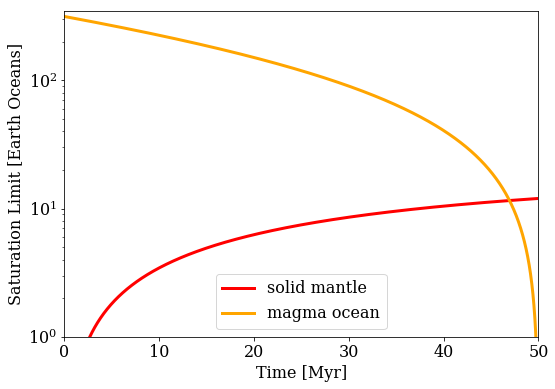

In [37]:
%matplotlib inline

plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(8.5,6))
plt.tight_layout()

plt.semilogy(t_array/year/1.0e6, W_sm_sat_array/1.4e21, color='r', linewidth=3, label='solid mantle')
plt.semilogy(t_array/year/1.0e6, W_mo_sat_array/1.4e21, color='orange', linewidth=3, label='magma ocean')
plt.xlabel('Time [Myr]', fontsize=16)
plt.ylabel('Saturation Limit [Earth Oceans]', fontsize=16)
plt.xlim([0., 50.0e6/1.0e6])
plt.ylim([1., 350.])
plt.legend(loc='lower center', fontsize=16)

In [38]:
print('Solid mantle: ', W_sm_sat_array[0]/1.4e21, 'Earth Oceans')

Solid mantle:  0.0 Earth Oceans


In [39]:
print(1.68e22*1e6/(h(M_E)*4.*np.pi*(Rp(M_E)**2.)*3.3e3))

3458.314300783742


# Divide water between solidifying mantle, liquid MO, and atmosphere (if liquid MO becomes supersaturated).

In [40]:
# Start with 10 Earth Oceans
W_total_i = 10.*1.4e21 # [kg]
dt = 2.0e4*year #20,000 yr per timestep
M = M_E

# Distribute into 3 reservoirs -- solid mantle, then magma ocean, then atmosphere.
W_sm_array = np.zeros(len(t_array))
W_mo_array = np.zeros(len(t_array))
W_atm_array = np.zeros(len(t_array))
F_H2O_array = np.zeros(len(t_array))

# Track MO/mantle temperature as well.
T_array = np.zeros(len(t_array))
T_array[0] = T_MO(0., M, a_orb, params1, params2, params3) # 4000K,  corresponds to a fully molten mantle
 
# Initially: fully molten mantle; no atmosphere; no solid mantle.
W_mo_array[0] = W_total_i
F_H2O_array[0] = W_total_i/(d_MO(t_array[0], M_E, a_orb, params1, params2, params3)*4.*np.pi*(Rp(M_E)**2.)*rho_MO)

for idx in range(1,len(t_array)):
    
    # Some MO solidifies; water in that 'wedge' partitioned between solid mantle and melt.
    W_part = ((d_MO_array[idx-1] - d_MO_array[idx])/d_MO_array[idx-1])*W_mo_array[idx-1]
    F_H2O_array[idx] = W_mo_array[idx]/(d_MO(t_array[idx], M_E, a_orb, params1, params2, params3)*4.*np.pi*(Rp(M_E)**2.)*rho_MO)
    
    # Mantle temperature evolution -- either water in liquid MO or solid mantle.
    T_array[idx] = T_MO(t_array[idx], M, a_orb, params1, params2, params3)
    #if f_melt(t_array[idx-1], T_array[idx-1], W_mo_array[idx-1], M, params1, params2, params3, params4) >= 0.4: 
        
    #    T_array[idx] = T_array[idx-1] + f_delta_temp(t_array[idx-1], T_array[idx-1], W_mo_array[idx-1], T_surf_OLR(t_array[idx-1], M, alb, a_orb, params1, params2, params3), a_orb, M, params1, params2, params3, params4)
    
    #else:
        
    #    T_array[idx] = T_array[idx-1] + f_delta_temp(t_array[idx-1], T_array[idx-1], W_sm_array[idx-1], T_surf_OLR(t_array[idx-1], M, alb, a_orb, params1, params2, params3), a_orb, M, params1, params2, params3, params4)

    
    if (W_sm_array[idx-1] + (0.01*W_part)) > W_sm_sat_array[idx]: #saturated mantle
        
        W_sm_array[idx] = W_sm_sat_array[idx]
        W_mo_array[idx] = W_mo_array[idx-1] - (W_sm_array[idx] - W_sm_array[idx-1])
        
        if W_mo_array[idx] > W_mo_sat_array[idx]:
            
            W_atm_array[idx] = W_atm_array[idx-1] + (W_mo_array[idx] - W_mo_sat_array[idx])
            W_mo_array[idx] = W_mo_sat_array[idx]
            
        else: #W_mo_array[idx] <= W_mo_sat_array[idx]
            
            #W_atm_array[idx] = 0.
            W_atm_array[idx] = W_atm_array[idx-1] 
        
    else: #(W_sm_array[idx-1] + (0.01*W_part)) <= W_sm_sat_array[idx]:
        
        W_sm_array[idx] = W_sm_array[idx-1] + (0.01*W_part)
        W_mo_array[idx] = W_mo_array[idx-1] - (0.01*W_part)
        
        if W_mo_array[idx] > W_mo_sat_array[idx]:
            
            W_atm_array[idx] = W_atm_array[idx-1] + (W_mo_array[idx] - W_mo_sat_array[idx])
            W_mo_array[idx] = W_mo_sat_array[idx]
            
        else:
            
            #W_atm_array[idx] += 0. 
            W_atm_array[idx] = W_atm_array[idx-1] 

In [41]:
# Save atmospheric water array for comparison with loss, below.
W_atm_array_noloss = W_atm_array

/Users/admin/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:1479: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ret = ax.set_ylim(*args, **kwargs)


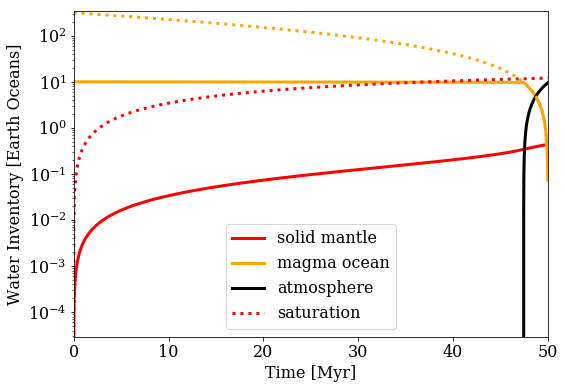

In [42]:
%matplotlib inline

plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(8.5,6))
plt.tight_layout()

plt.semilogy(t_array/year/1.0e6, W_sm_array/1.4e21, color='r', linewidth=3, label='solid mantle')
plt.semilogy(t_array/year/1.0e6, W_mo_array/1.4e21, color='orange', linewidth=3, label='magma ocean')
plt.semilogy(t_array/year/1.0e6, W_atm_array/1.4e21, color='k', linewidth=3, label='atmosphere')
plt.semilogy(t_array/year/1.0e6, W_sm_sat_array/1.4e21, color='r', linewidth=3, linestyle=':', label='saturation')
plt.semilogy(t_array/year/1.0e6, W_mo_sat_array/1.4e21, color='orange', linewidth=3, linestyle=':')
plt.xlabel('Time [Myr]', fontsize=16)
plt.ylabel('Water Inventory [Earth Oceans]', fontsize=16)
plt.xlim([0., 50.0e6/1.0e6])
plt.ylim([0., 350.])
plt.legend(loc='lower center', fontsize=16)

In [43]:
print(W_sm_array[-1]/1.4e21)

0.4380397078025801


(0.0, 4400.0)

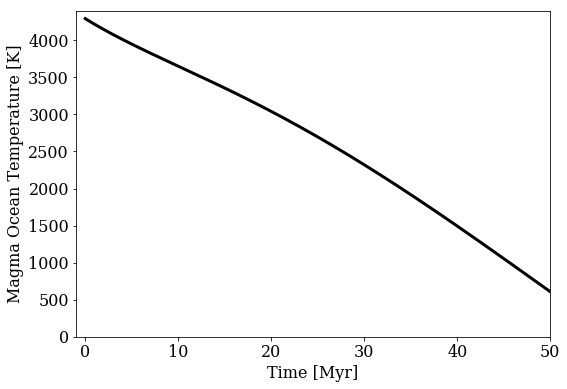

In [44]:
%matplotlib inline

plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(8.5,6))
plt.tight_layout()

plt.plot(t_array/year/1.0e6, T_array, color='k', linewidth=3)
plt.xlabel('Time [Myr]', fontsize=16)
plt.ylabel('Magma Ocean Temperature [K]', fontsize=16)
plt.xlim([-1., 50.0e6/1.0e6])
plt.ylim([0., 4400.])

In [45]:
print(T_array[2])

4289.166941128889


## Add atmospheric loss, and plot again. XXXX TO DO XXXX

In [46]:
# Start with 10 Earth Oceans
W_total_i = 10.*1.4e21 # [kg]
dt = 2.0e4*year #20,000 yr per timestep
M = M_E

# Distribute into 3 reservoirs -- solid mantle, then magma ocean, then atmosphere.
W_sm_array = np.zeros(len(t_array))
W_mo_array = np.zeros(len(t_array))
W_atm_array = np.zeros(len(t_array))
F_H2O_array = np.zeros(len(t_array))
EL_loss_array = np.zeros(len(t_array))

# Track MO/mantle temperature as well.
T_array = np.zeros(len(t_array))
T_array[0] = T_MO(0., M, a_orb, params1, params2, params3) # 4000K,  corresponds to a fully molten mantle
 
# Initially: fully molten mantle; no atmosphere; no solid mantle.
W_mo_array[0] = W_total_i
F_H2O_array[0] = W_total_i/(d_MO(t_array[0], M_E, a_orb, params1, params2, params3)*4.*np.pi*(Rp(M_E)**2.)*rho_MO)
EL_loss_array[0] = (loss_rate_EL(t_array[0], F_XUV(t_array[0], M_E, a_orb, params1, params2, params3), Rp(M), M)*dt)

# Track the total amount of water lost, once an atmosphere forms, by EL loss, and potential total that could be lost.
water_lost = 0.
total_water_lost = 0.

for idx in range(1,len(t_array)):
    
    # Some MO solidifies; water in that 'wedge' partitioned between solid mantle and melt.
    W_part = ((d_MO_array[idx-1] - d_MO_array[idx])/d_MO_array[idx-1])*W_mo_array[idx-1]
    F_H2O_array[idx] = W_mo_array[idx]/(d_MO(t_array[idx], M_E, a_orb, params1, params2, params3)*4.*np.pi*(Rp(M_E)**2.)*rho_MO)
    
    # Loss rate at a given timestep
    EL_loss_array[0] = (loss_rate_EL(t_array[idx], F_XUV(t_array[idx], M_E, a_orb, params1, params2, params3), Rp(M), M)*dt)

    # Mantle temperature evolution -- either water in liquid MO or solid mantle.
    T_array[idx] = T_MO(t_array[idx], M, a_orb, params1, params2, params3)
    #if f_melt(t_array[idx-1], T_array[idx-1], W_mo_array[idx-1], M, params1, params2, params3, params4) >= 0.4: 
        
    #    T_array[idx] = T_array[idx-1] + f_delta_temp(t_array[idx-1], T_array[idx-1], W_mo_array[idx-1], T_surf_OLR(t_array[idx-1], M, alb, a_orb, params1, params2, params3), a_orb, M, params1, params2, params3, params4)
    
    #else:
        
    #    T_array[idx] = T_array[idx-1] + f_delta_temp(t_array[idx-1], T_array[idx-1], W_sm_array[idx-1], T_surf_OLR(t_array[idx-1], M, alb, a_orb, params1, params2, params3), a_orb, M, params1, params2, params3, params4)

    
    if (W_sm_array[idx-1] + (0.01*W_part)) > W_sm_sat_array[idx]: #saturated mantle
        
        W_sm_array[idx] = W_sm_sat_array[idx]
        W_mo_array[idx] = W_mo_array[idx-1] - (W_sm_array[idx] - W_sm_array[idx-1])
        
        if W_mo_array[idx] > W_mo_sat_array[idx]:
            
            W_atm_array[idx] = W_atm_array[idx-1] + (W_mo_array[idx] - W_mo_sat_array[idx])
            W_mo_array[idx] = W_mo_sat_array[idx]
            
        else: #W_mo_array[idx] <= W_mo_sat_array[idx]
            
            #W_atm_array[idx] = 0.
            W_atm_array[idx] = W_atm_array[idx-1] 
        
    else: #(W_sm_array[idx-1] + (0.01*W_part)) <= W_sm_sat_array[idx]:
        
        W_sm_array[idx] = W_sm_array[idx-1] + (0.01*W_part)
        W_mo_array[idx] = W_mo_array[idx-1] - (0.01*W_part)
        
        if W_mo_array[idx] > W_mo_sat_array[idx]:
            
            W_atm_array[idx] = W_atm_array[idx-1] + (W_mo_array[idx] - W_mo_sat_array[idx])
            W_mo_array[idx] = W_mo_sat_array[idx]
            
        else:
            
            #W_atm_array[idx] += 0. 
            W_atm_array[idx] = W_atm_array[idx-1] 
            
        # Now that the water is partitioned, account for energy-limited loss from growing atmosphere.
        if (W_atm_array[idx] - (loss_rate_EL(t_array[idx], F_XUV(t_array[idx], M_E, a_orb, params1, params2, params3), Rp(M_E), M_E)*dt)) >= 0.:
            
            W_atm_array[idx] = W_atm_array[idx-1] - (loss_rate_EL(t_array[idx], F_XUV(t_array[idx], M_E, a_orb, params1, params2, params3), Rp(M_E), M_E)*dt)
            water_lost += (W_atm_array[idx-1] - W_atm_array[idx])
            total_water_lost += (loss_rate_EL(t_array[idx], F_XUV(t_array[idx], M_E, a_orb, params1, params2, params3), Rp(M_E), M_E)*dt)
            
        else:
            
            W_atm_array[idx] = 0.

In [47]:
print('Water lost to space: ', water_lost/1.4e21, 'Earth Oceans')
print('TOTAL potential water loss: ', total_water_lost/1.4e21, 'Earth Oceans')

Water lost to space:  0.02062989901893295 Earth Oceans
TOTAL potential water loss:  0.02062989901893295 Earth Oceans


/Users/admin/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:1479: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ret = ax.set_ylim(*args, **kwargs)


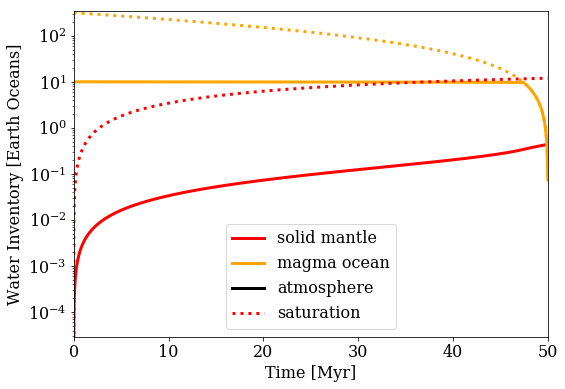

In [48]:
%matplotlib inline

plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(8.5,6))
plt.tight_layout()

plt.semilogy(t_array/year/1.0e6, W_sm_array/1.4e21, color='r', linewidth=3, label='solid mantle')
plt.semilogy(t_array/year/1.0e6, W_mo_array/1.4e21, color='orange', linewidth=3, label='magma ocean')
plt.semilogy(t_array/year/1.0e6, W_atm_array/1.4e21, color='k', linewidth=3, label='atmosphere')
plt.semilogy(t_array/year/1.0e6, W_sm_sat_array/1.4e21, color='r', linewidth=3, linestyle=':', label='saturation')
plt.semilogy(t_array/year/1.0e6, W_mo_sat_array/1.4e21, color='orange', linewidth=3, linestyle=':')
plt.xlabel('Time [Myr]', fontsize=16)
plt.ylabel('Water Inventory [Earth Oceans]', fontsize=16)
plt.xlim([0., 50.0e6/1.0e6])
plt.ylim([0., 350.])
plt.legend(loc='lower center', fontsize=16)

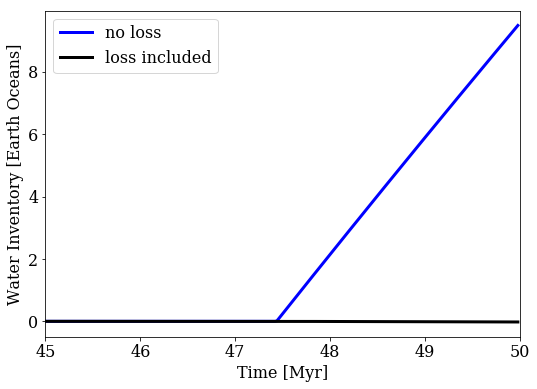

In [49]:
%matplotlib inline

plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(8.5,6))
plt.tight_layout()

plt.plot(t_array/year/1.0e6, W_atm_array_noloss/1.4e21, color='b', linewidth=3, label='no loss')
plt.plot(t_array/year/1.0e6, W_atm_array/1.4e21, color='k', linewidth=3, label='loss included')
plt.xlabel('Time [Myr]', fontsize=16)
plt.ylabel('Water Inventory [Earth Oceans]', fontsize=16)
plt.xlim([45.0e6/1.0e6, 50.0e6/1.0e6])
#plt.ylim([0., 350.])
plt.legend(loc='upper left', fontsize=16)

# Alternative way -- distribute into reservoirs.

In [50]:
# Start with 10 Earth Oceans
W_total_i = 10.*1.4e21 # [kg]

# Distribute into 3 reservoirs -- solid mantle, then magma ocean, then atmosphere.
W_sm_array = np.zeros(len(t_array))
W_mo_array = np.zeros(len(t_array))
W_atm_array = np.zeros(len(t_array))

if W_total_i >= W_sm_sat_array[0]: # solid mantle saturated
    
    W_sm_array[0] = W_sm_sat_array[0]
    W_total = W_total_i - W_sm_array[0]
    
    if W_total >= W_mo_sat_array[0]: # magma ocean saturated
        
        W_mo_array[0] = W_mo_sat_array[0]
        W_atm_array[0] = W_total - W_mo_array[0]
        
    else: # magma ocean NOT saturated
        
        W_mo_array[0] = W_total
        W_atm_array[0] = 0.
        
else: # solid mantle NOT saturated
    
    W_sm_array[0] = W_total_i
    W_mo_array[0] = 0.
    W_atm_array[0] = 0.

In [51]:
print('Solid mantle: ', W_sm_array[0]/1.4e21, 'Earth Oceans')
print('Magma ocean: ', W_mo_array[0]/1.4e21, 'Earth Oceans')
print('Atmosphere: ', W_atm_array[0]/1.4e21, 'Earth Oceans')

Solid mantle:  0.0 Earth Oceans
Magma ocean:  10.0 Earth Oceans
Atmosphere:  0.0 Earth Oceans


# Set up a loop to go through the entire MO evolution.

In [52]:
for idx in range(1,len(t_array)):
    
    # Some MO solidifies; water in that 'wedge' partitioned between solid mantle and melt.
    W_part = ((d_MO_array[idx-1] - d_MO_array[idx])/d_MO_array[idx-1])*W_mo_array[idx-1]
    
    if (W_sm_array[idx-1] + (0.01*W_part)) > W_sm_sat_array[idx]: #saturated mantle
        
        W_sm_array[idx] = W_sm_sat_array[idx]
        W_mo_array[idx] = W_mo_array[idx-1] - (W_sm_array[idx] - W_sm_array[idx-1])
        
        if W_mo_array[idx] > W_mo_sat_array[idx]:
            
            W_atm_array[idx] = W_atm_array[idx-1] + (W_mo_array[idx] - W_mo_sat_array[idx])
            W_mo_array[idx] = W_mo_sat_array[idx]
            
        else: #W_mo_array[idx] <= W_mo_sat_array[idx]
            
            #W_atm_array[idx] = 0.
            W_atm_array[idx] = W_atm_array[idx-1] 
        
    else: #(W_sm_array[idx-1] + (0.01*W_part)) <= W_sm_sat_array[idx]:
        
        W_sm_array[idx] = W_sm_array[idx-1] + (0.01*W_part)
        W_mo_array[idx] = W_mo_array[idx-1] - (0.01*W_part)
        
        if W_mo_array[idx] > W_mo_sat_array[idx]:
            
            W_atm_array[idx] = W_atm_array[idx-1] + (W_mo_array[idx] - W_mo_sat_array[idx])
            W_mo_array[idx] = W_mo_sat_array[idx]
            
        else:
            
            #W_atm_array[idx] += 0. 
            W_atm_array[idx] = W_atm_array[idx-1] 

In [53]:
print(((d_MO_array[0] - d_MO_array[1])/d_MO_array[0])*W_mo_array[0])

8.85729798077445e+18


In [54]:
print((d_MO_array[0] - d_MO_array[1])/d_MO_array[0])

0.0006326641414838893


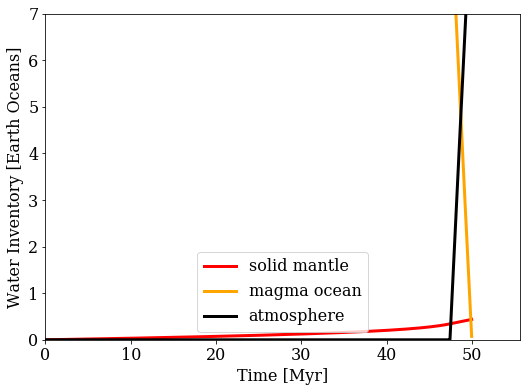

In [55]:
%matplotlib inline

plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(8.5,6))
plt.tight_layout()

plt.plot(t_array/year/1.0e6, W_sm_array/1.4e21, color='r', linewidth=3, label='solid mantle')
plt.plot(t_array/year/1.0e6, W_mo_array/1.4e21, color='orange', linewidth=3, label='magma ocean')
plt.plot(t_array/year/1.0e6, W_atm_array/1.4e21, color='k', linewidth=3, label='atmosphere')
plt.xlabel('Time [Myr]', fontsize=16)
plt.ylabel('Water Inventory [Earth Oceans]', fontsize=16)
plt.xlim([0., tau_RG(M_E, a_orb, alb, params1, params2, params3)/year/1.0e6])
plt.ylim([0., 7.])
plt.legend(loc='lower center', fontsize=16)

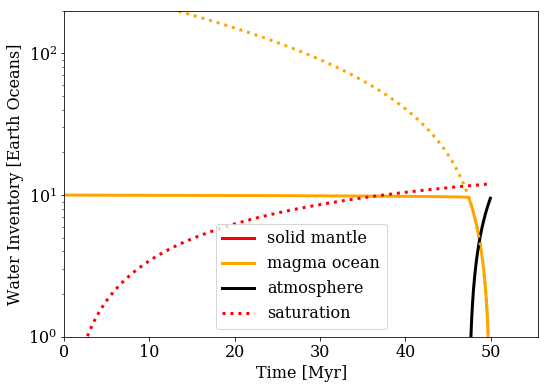

In [56]:
%matplotlib inline

plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(8.5,6))
plt.tight_layout()

plt.semilogy(t_array/year/1.0e6, W_sm_array/1.4e21, color='r', linewidth=3, label='solid mantle')
plt.semilogy(t_array/year/1.0e6, W_mo_array/1.4e21, color='orange', linewidth=3, label='magma ocean')
plt.semilogy(t_array/year/1.0e6, W_atm_array/1.4e21, color='k', linewidth=3, label='atmosphere')
plt.semilogy(t_array/year/1.0e6, W_sm_sat_array/1.4e21, color='r', linewidth=3, linestyle=':', label='saturation')
plt.semilogy(t_array/year/1.0e6, W_mo_sat_array/1.4e21, color='orange', linewidth=3, linestyle=':')
plt.xlabel('Time [Myr]', fontsize=16)
plt.ylabel('Water Inventory [Earth Oceans]', fontsize=16)
plt.xlim([0., tau_RG(M_E, a_orb, alb, params1, params2, params3)/year/1.0e6])
plt.ylim([1., 200.])
plt.legend(loc='best', fontsize=16)

In [57]:
print('Atmosphere: ', W_atm_array[-3]/1.4e21, 'Earth Oceans')
print('Solid mantle: ', W_sm_array[-3]/1.4e21, 'Earth Oceans')

Atmosphere:  9.34299969026883 Earth Oceans
Solid mantle:  0.43656987770140726 Earth Oceans


## Looks alright -- now add atmospheric loss to the loop, and plot again.

In [58]:
for idx in range(1,len(t_array)):
    
    # Some MO solidifies; water in that 'wedge' partitioned between solid mantle and melt.
    W_part = ((d_MO_array[idx-1] - d_MO_array[idx])/d_MO_array[idx-1])*W_mo_array[idx-1]
    
    if (W_sm_array[idx-1] + (0.01*W_part)) > W_sm_sat_array[idx]: #saturated mantle
        
        W_sm_array[idx] = W_sm_sat_array[idx]
        W_mo_array[idx] = W_mo_array[idx-1] - (W_sm_array[idx] - W_sm_array[idx-1])
        
        if W_mo_array[idx] > W_mo_sat_array[idx]:
            
            W_atm_array[idx] = W_atm_array[idx-1] + (W_mo_array[idx] - W_mo_sat_array[idx])
            W_mo_array[idx] = W_mo_sat_array[idx]
            
        else: #W_mo_array[idx] <= W_mo_sat_array[idx]
            
            #W_atm_array[idx] += 0.
            W_atm_array[idx] = W_atm_array[idx-1] 
        
    else: #(W_sm_array[idx-1] + (0.01*W_part)) <= W_sm_sat_array[idx]:
        
        W_sm_array[idx] = W_sm_array[idx-1] + (0.01*W_part)
        W_mo_array[idx] = W_mo_array[idx-1] - (0.01*W_part)
        
        if W_mo_array[idx] > W_mo_sat_array[idx]:
            
            W_atm_array[idx] = W_atm_array[idx-1] + (W_mo_array[idx] - W_mo_sat_array[idx])
            W_mo_array[idx] = W_mo_sat_array[idx]
            
        else:
            
            #W_atm_array[idx] += 0. 
            W_atm_array[idx] = W_atm_array[idx-1] 
            
    # Now that the water is partitioned, account for energy-limited loss from growing atmosphere.
        if (W_atm_array[idx] - (loss_rate_EL(t_array[idx], F_XUV(t_array[idx], M_E, a_orb, params1, params2, params3), Rp(M_E), M_E)*dt)) >= 0.:
            
            W_atm_array[idx] -= (loss_rate_EL(t_array[idx], F_XUV(t_array[idx], M_E, a_orb, params1, params2, params3), Rp(M_E), M_E)*dt)
            
        else:
            
            W_atm_array[idx] = 0.

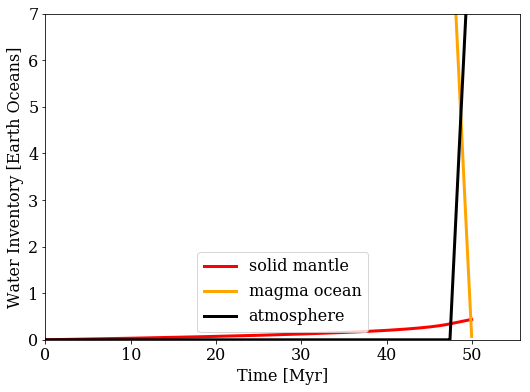

In [59]:
%matplotlib inline

plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(8.5,6))
plt.tight_layout()

plt.plot(t_array/year/1.0e6, W_sm_array/1.4e21, color='r', linewidth=3, label='solid mantle')
plt.plot(t_array/year/1.0e6, W_mo_array/1.4e21, color='orange', linewidth=3, label='magma ocean')
plt.plot(t_array/year/1.0e6, W_atm_array/1.4e21, color='k', linewidth=3, label='atmosphere')
plt.xlabel('Time [Myr]', fontsize=16)
plt.ylabel('Water Inventory [Earth Oceans]', fontsize=16)
plt.xlim([0., tau_RG(M_E, a_orb, alb, params1, params2, params3)/year/1.0e6])
plt.ylim([0., 7.])
plt.legend(loc='lower center', fontsize=16)

In [60]:
print('Atmosphere/surface: ', W_atm_array[-3]/1.4e21, 'Earth Oceans')
print('Solid mantle: ', W_sm_array[-3]/1.4e21, 'Earth Oceans')

Atmosphere/surface:  9.322686686298029 Earth Oceans
Solid mantle:  0.43656987770140726 Earth Oceans


In [61]:
print('Water lost: ', (6.011285309384759-6.011137296873709)*1.4e21, 'kg')

Water lost:  2.0721751546908253e+17 kg


# ChEd's plug-and-play model -- see notes he sent me for details

In [117]:
# Initial/constant parameters
C_sat = 0.1 #0.1 OR 0.01 (degassing earlier with lower C_sat) #[wt fraction]; H2O saturation limit of MO
C_0 = 0.005 #[wt fraction]; initial H2O concentration of MO
D = 0.001 #0.001 OR 0.1 (more water stored in mantle for larger D) #solid-liquid H2O distribution coefficient
R_p = 6400. #[km]
R_c = 3000. #[km]
rho = 3.0e3*1.0e9 #[kg/km^3] XXXX USE A SINGLE VALUE FOR RHO, FOR NOW XXXX
rho_MO = rho
rho_m = rho

def d_MO_test(t): #[km]
    
    d_MO_0 = R_p - R_c # ENTIRE MANTLE BEGINS MOLTEN ##2000.0e3 #[m]
    beta_MO = 1./(np.exp(1.)-1)
    
    # TEST MULTIPLE TIMESCALES FOR NOMINAL MODEL -- 10, 50, 100 Myr (50 Myr as nominal)
    tau_MO = 50.0e6*year #conservatively chosen estimate, for mid-HZ, from Barth+2020 Fig. 5
    
    return (beta_MO*d_MO_0)*(np.exp((-t/tau_MO) + 1.) - 1)

# Required functions -- RECALL (r = R_p - d_MO(t))
def C_l(r):
    
    return C_0*((R_p**3.-R_c**3.)/(R_p**3.-r**3.))**(1.-D)

def C_s(r):
    
    return D*C_l(r)

def R_sat():
    
    return (R_p**3. - ((R_p**3. - R_c**3.)/((C_sat/C_0)**(1./(1.-D)))))**(1./3.)

def M_MO_unsat(r):
    
    return C_l(r)*(4.*np.pi/3.)*rho_MO*(R_p**3. - r**3.)

def M_SM_unsat(r):
    
    return C_0*(4.*np.pi/3.)*rho_m*((R_p**3. - R_c**3.)**(1.-D))*\
            (((R_p**3. - R_c**3.)**D) - ((R_p**3. - r**3.)**D))

def M_MO_sat(r):
    
    return C_sat*(4.*np.pi/3.)*rho_MO*(R_p**3. - r**3.)

def M_SM_sat(r):
    
    return M_SM_unsat(R_sat()) + D*C_sat*(4.*np.pi/3.)*rho_m*(r**3.-R_sat()**3.)

In [118]:
# Loop to determine whether or not MO is saturated & degas an atmosphere if it is
dt = 2.0e4*year #20,000 yr per timestep
t_array = np.arange(0., 50.0e6*year, dt)

# Initial water inventory
M_init = C_0*(4.*np.pi/3.)*rho*(R_p**3. - R_c**3.) #[kg]; 10 Earth Oceans (where 1 EO = 1.4e21 kg)

r_array = R_p - d_MO_test(t_array) #[km]
#r_array = np.arange(3000., 6400., 50.)
M_MO_array = np.zeros(len(r_array))
M_SM_array = np.zeros(len(r_array))
M_atmo_array = np.zeros(len(r_array))

# Track MO temperature as a function of r/t.
T_array = np.zeros(len(t_array))
T_array[0] = T_MO(0., M, a_orb, params1, params2, params3) # 4000K,  corresponds to a fully molten mantle

for idx in range(0,len(r_array)):
    
    T_array[idx] = T_MO(t_array[idx], M, a_orb, params1, params2, params3)
    
    #MO undersaturated with water, i.e., r <= R_sat
    if r_array[idx] <= R_sat():
        
        M_MO_array[idx] = M_MO_unsat(r_array[idx])
        
        M_SM_array[idx] = M_SM_unsat(r_array[idx])
        
        M_atmo_array[idx] = 0.
        
    # MO saturated/supersaturated with water (r > R_sat); atmosphere forms    
    else: #r_array[idx] > R_sat()
        
        M_MO_array[idx] = M_MO_sat(r_array[idx])
        
        M_SM_array[idx] = M_SM_sat(r_array[idx])
        
        M_atmo_array[idx] = M_init - M_SM_sat(r_array[idx]) - M_MO_sat(r_array[idx])

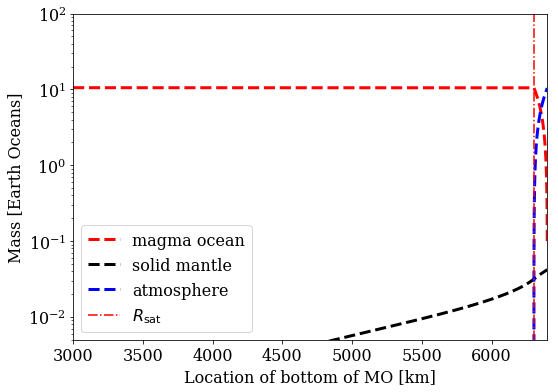

In [119]:
%matplotlib inline

plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(8.5,6))
plt.tight_layout()

plt.semilogy(r_array, M_MO_array/1.4e21, color='r', linestyle='--', linewidth=3, label='magma ocean')
plt.semilogy(r_array, M_SM_array/1.4e21, color='k', linestyle='--', linewidth=3, label='solid mantle')
plt.semilogy(r_array, M_atmo_array/1.4e21, color='b', linestyle='--', linewidth=3, label='atmosphere')
plt.axvline(x=R_sat(), color='r', linestyle='-.', label=r'$R_\mathrm{{sat}}$')
plt.xlabel('Location of bottom of MO [km]', fontsize=16)
plt.ylabel('Mass [Earth Oceans]', fontsize=16)
plt.xlim(3000., 6400.)
plt.ylim(0.005, 100.)
plt.legend(loc='lower left', fontsize=16)

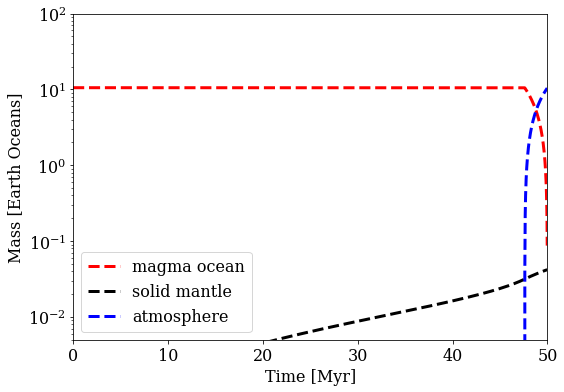

In [99]:
# Can also be plotted as a function of time.
%matplotlib inline

plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(8.5,6))
plt.tight_layout()

plt.semilogy(t_array/year/1.0e6, M_MO_array/1.4e21, color='r', linestyle='--', linewidth=3, label='magma ocean')
plt.semilogy(t_array/year/1.0e6, M_SM_array/1.4e21, color='k', linestyle='--', linewidth=3, label='solid mantle')
plt.semilogy(t_array/year/1.0e6, M_atmo_array/1.4e21, color='b', linestyle='--', linewidth=3, label='atmosphere')
plt.xlabel('Time [Myr]', fontsize=16)
plt.ylabel('Mass [Earth Oceans]', fontsize=16)
plt.xlim([0., 50.])
plt.ylim(0.005, 100.)
plt.legend(loc='lower left', fontsize=16)

(0.0, 4400.0)

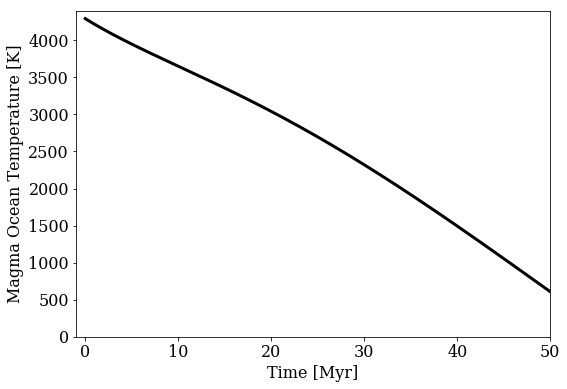

In [100]:
%matplotlib inline

plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(8.5,6))
plt.tight_layout()

plt.plot(t_array/year/1.0e6, T_array, color='k', linewidth=3)
plt.xlabel('Time [Myr]', fontsize=16)
plt.ylabel('Magma Ocean Temperature [K]', fontsize=16)
plt.xlim([-1., 50.0e6/1.0e6])
plt.ylim([0., 4400.])

In [101]:
print('R_sat: ', R_sat(), 'km')
for idx in range(0,len(r_array)):
    
    if r_array[idx] > R_sat():
        
        sat_idx = idx
        break
        
print('Saturated at t = ', t_array[sat_idx]/year/1.0e6, 'Myr')
print(sat_idx)
print(len(t_array))

R_sat:  6303.147867285891 km
Saturated at t =  47.62 Myr
2381
2500


## Looks really good (could probably be what I end up using).
## Now, let's add atmospheric loss to the loop, and plot the results.

In [120]:
# Initial/constant parameters
C_sat = 0.1 #0.1 OR 0.01 (degassing earlier with lower C_sat) #[wt fraction]; H2O saturation limit of MO
C_0 = 0.005 #[wt fraction]; initial H2O concentration of MO
D = 0.001 #0.001 OR 0.1 (more water stored in mantle for larger D) #solid-liquid H2O distribution coefficient
R_p = 6400. #[km]
R_c = 3000. #[km]
rho = 3.0e3*1.0e9 #[kg/km^3] XXXX USE A SINGLE VALUE FOR RHO, FOR NOW XXXX
rho_MO = rho
rho_m = rho

def d_MO_test(t): #[km]
    
    d_MO_0 = R_p - R_c # ENTIRE MANTLE BEGINS MOLTEN ##2000.0e3 #[m]
    beta_MO = 1./(np.exp(1.)-1)
    
    # TEST MULTIPLE TIMESCALES FOR NOMINAL MODEL -- 10, 50, 100 Myr (50 Myr as nominal)
    tau_MO = 50.0e6*year #conservatively chosen estimate, for mid-HZ, from Barth+2020 Fig. 5
    
    return (beta_MO*d_MO_0)*(np.exp((-t/tau_MO) + 1.) - 1)

# Required functions -- RECALL (r = R_p - d_MO(t))
def C_l(r):
    
    return C_0*((R_p**3.-R_c**3.)/(R_p**3.-r**3.))**(1.-D)

def C_s(r):
    
    return D*C_l(r)

def R_sat():
    
    return (R_p**3. - ((R_p**3. - R_c**3.)/((C_sat/C_0)**(1./(1.-D)))))**(1./3.)

def M_MO_unsat(r):
    
    return C_l(r)*(4.*np.pi/3.)*rho_MO*(R_p**3. - r**3.)

def M_SM_unsat(r):
    
    return C_0*(4.*np.pi/3.)*rho_m*((R_p**3. - R_c**3.)**(1.-D))*\
            (((R_p**3. - R_c**3.)**D) - ((R_p**3. - r**3.)**D))

def M_MO_sat(r):
    
    return C_sat*(4.*np.pi/3.)*rho_MO*(R_p**3. - r**3.)

def M_SM_sat(r):
    
    return M_SM_unsat(R_sat()) + D*C_sat*(4.*np.pi/3.)*rho_m*(r**3. - R_sat()**3.)

In [121]:
def loss_rate_EL(t, F_XUV, M): #[kg/s]
    
    # R_XUV = XUV deposition radius; LB15 set R_XUV = R_p for simplicity
    # M = planetary mass
    R_p = 6400.*1000. #[m]
    
    G = 6.67e-11
    eps_XUV = 0.1 #nominal; LB15 test 0.15-0.30
    
    return eps_XUV*np.pi*F_XUV*(R_p**3.)/(G*M)

In [124]:
# Loop to determine whether or not MO is saturated & degas an atmosphere if it is
dt = 2.0e4*year #20,000 yr per timestep
t_array = np.arange(0., 50.0e6*year, dt)

# Initial water inventory
M_init = C_0*(4.*np.pi/3.)*rho*(R_p**3. - R_c**3.) #[kg]; 10 Earth Oceans (where 1 EO = 1.4e21 kg)

r_array = R_p - d_MO_test(t_array) #[km]
#r_array = np.arange(3000., 6400., 50.)
M_MO_array = np.zeros(len(r_array))
M_SM_array = np.zeros(len(r_array))
M_atmo_array = np.zeros(len(r_array))
EL_loss_array = np.zeros(len(r_array))
a_orb_test = 0.1*0.06727532*1.496e11 #[m]

# Keep track of the total water inventory, since it decreases with loss.
M_total = M_init

for idx in range(0,len(r_array)):
    
    EL_loss_array[idx] = loss_rate_EL(t_array[idx], F_XUV(t_array[idx], M, a_orb_test, params1, params2, params3), M_E)
    
    #MO undersaturated with water, i.e., r <= R_sat
    if r_array[idx] <= R_sat():
        
        M_MO_array[idx] = M_MO_unsat(r_array[idx])
        
        M_SM_array[idx] = M_SM_unsat(r_array[idx])
        
        M_atmo_array[idx] = 0.
        
    # MO saturated/supersaturated with water (r > R_sat); atmosphere forms    
    else: #r_array[idx] > R_sat()
        
        M_MO_array[idx] = M_MO_sat(r_array[idx])
        
        M_SM_array[idx] = M_SM_sat(r_array[idx])
        
        M_atmo_array[idx] = M_total - M_SM_sat(r_array[idx]) - M_MO_sat(r_array[idx])
        
        # Now add loss:
        if M_atmo_array[idx] <= (EL_loss_array[idx]*dt):
            
            M_total = M_total - M_atmo_array[idx]
            M_atmo_array[idx] = 0.
            
        else: #M_atmo_array[idx] > (EL_loss_array[idx]*dt)
            
            M_atmo_array[idx] = M_atmo_array[idx] - (EL_loss_array[idx]*dt)
            M_total = M_total - (EL_loss_array[idx]*dt)

In [125]:
print('Initial water = ', M_init/1.4e21, 'Earth Oceans')
print('Final water = ', M_total/1.4e21, 'Earth Oceans')
print('Water lost = ', (M_init - M_total)/1.4e21, 'Earth Oceans')

Initial water =  10.553238041938833 Earth Oceans
Final water =  8.611242088699782 Earth Oceans
Water lost =  1.941995953239051 Earth Oceans


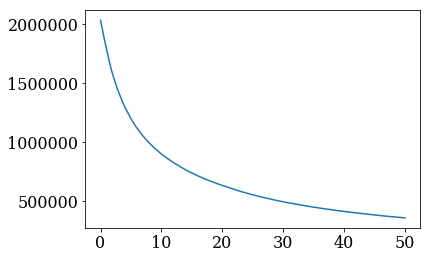

In [106]:
plt.plot(t_array/year/1.0e6, EL_loss_array)

In [107]:
print('Max possible water lost, once atmosphere forms: ', (np.sum(EL_loss_array[sat_idx:])*dt)/1.4e21, 'Earth Oceans')
print('Max possible water lost, if EL the entire time: ', (np.sum(EL_loss_array)*dt)/1.4e21, 'Earth Oceans')

Max possible water lost, once atmosphere forms:  0.01941995953239051 Earth Oceans
Max possible water lost, if EL the entire time:  0.7698690277724674 Earth Oceans


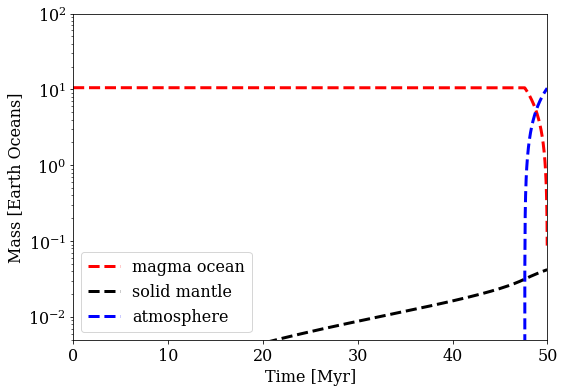

In [108]:
# Can also be plotted as a function of time.
%matplotlib inline

plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(8.5,6))
plt.tight_layout()

plt.semilogy(t_array/year/1.0e6, M_MO_array/1.4e21, color='r', linestyle='--', linewidth=3, label='magma ocean')
plt.semilogy(t_array/year/1.0e6, M_SM_array/1.4e21, color='k', linestyle='--', linewidth=3, label='solid mantle')
plt.semilogy(t_array/year/1.0e6, M_atmo_array/1.4e21, color='b', linestyle='--', linewidth=3, label='atmosphere')
plt.xlabel('Time [Myr]', fontsize=16)
plt.ylabel('Mass [Earth Oceans]', fontsize=16)
plt.xlim([0., 50.])
plt.ylim(0.005, 100.)
plt.legend(loc='lower left', fontsize=16)

# Fix stellar model -- use offset of 5 Myr to account for formation, and just interpolate within the arrays.

In [75]:
# Stellar evolution and surface temperature calculations

# Stellar evolution track for 0.13 Msun star (similar to Proxima Cen), from Baraffe+ 2015
# Read in stellar evolution track data
data = np.loadtxt('BHAC15_0.13Msun.txt', skiprows=3)
#data = np.loadtxt('BHAC15_0.3Msun.txt', skiprows=3)
log_age = data[:,1] #log(yr)
T_eff = data[:,2] #[K]
Lbol_Ls = data[:,3] #log luminosity
R_Rs = data[:,5]

Ls = 3.839e33 # [erg/s]; solar bolometric luminosity
Lbol_data = np.zeros(len(Lbol_Ls))
for idx in range(0,len(Lbol_Ls)):    
    Lbol_data[idx] = (10.**Lbol_Ls[idx])*Ls/1.0e7 #[W]
    
Rs = 6.96e10 #[cm]; solar radius
Rstar = (R_Rs*Rs)/100.0 #[m]

star_age_data = np.zeros(len(log_age)) #[s], for later calculations

# Convert stellar age to time, in seconds.
for idx in range(0,len(log_age)):
    star_age_data[idx] = ((10.0**log_age[idx])*year)

# Now, need to offset all arrays, based on ***5 Myr (Barth+20)*** assumed formation timescale.
for idx in range(0,len(star_age_data)):
    if (star_age_data[idx])/year > 5.0e6: #1.0e7
        start_idx = idx
        #print(start_idx, (star_age_data[start_idx])/year, 'years')
        break
        
# Offset, based on this -- ~5 Myr start time, using [idx] as the starting point.
Lbol = np.delete(Lbol_data, np.s_[0:start_idx-1])
star_age = np.delete(star_age_data, np.s_[0:start_idx-1])

# Now, need to start star_age at 0., to correspond with simulations (i.e., initialized at a t=0.)
print('Stellar age: ', star_age[0]/year, 'years')
star_age = star_age-(star_age[0])
#print(star_age[0])
    
# Calculate the top-of-atmosphere bolometric flux, from BHAC15 model.
def S_0(t, M, a_orb, params1, params2, params3):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt_nom = params3
    
    return np.interp(t, star_age, Lbol)/(4.*np.pi*(a_orb**2.))
    
# Calculate evolution of XUV luminosity (Luger & Barnes 2015; Ribas+ 2005)
def L_XUV(t, M, params1, params2, params3):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt_nom = params3
    
    f_sat = 1.0e-3 #saturation fraction
    t_sat = 1.0e9*year #[s], saturation timescale, XXXX SHOULD VARY THIS WHEN TESTING, BASED ON RECENT PAPERS!!! XXXX
    beta_XUV = -1.23
    
    if t <= t_sat:
        return f_sat*np.interp(t, star_age, Lbol)
    else: #t > t_sat
        return f_sat*((t/t_sat)**beta_XUV)*np.interp(t, star_age, Lbol)

# Calculate top-of-atmosphere XUV flux. 
def F_XUV(t, M, a_orb, params1, params2, params3):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt_nom = params3
        
    return L_XUV(t, M, params1, params2, params3)/(4.*np.pi*(a_orb**2.))

Stellar age:  4943197.926100546 years


In [76]:
dt = 2.0e4*year #20,000 yr per timestep
t_array = np.arange(0., 50.0e6*year, dt)

In [77]:
dt = 2.0e4*year #20,000 yr per timestep
t_array = np.arange(0., 50.0e6*year, dt)

F_XUV_array_1 = np.zeros(len(t_array))
for idx in range(0, len(t_array)): 
    
    F_XUV_array_1[idx] = F_XUV(t_array[idx], M_E, a_orb_test, params1, params2, params3)

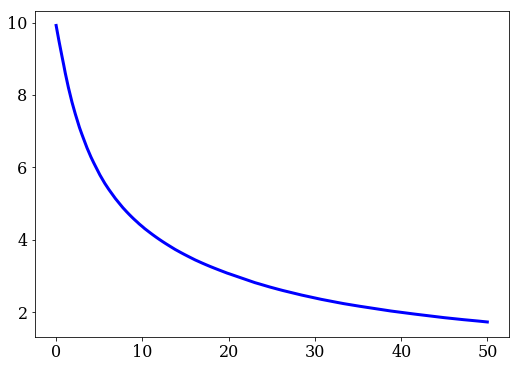

In [78]:
%matplotlib inline

plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(8.5,6))
plt.tight_layout()

plt.plot(t_array/year/1.0e6, F_XUV_array_1, color='b', linewidth=3)

### Do this again, but instead of deleting rows, just use an offset when interpolating.

In [79]:
# Stellar evolution and surface temperature calculations

# Stellar evolution track for 0.13 Msun star (similar to Proxima Cen), from Baraffe+ 2015
# Read in stellar evolution track data
data = np.loadtxt('BHAC15_0.13Msun.txt', skiprows=3)
#data = np.loadtxt('BHAC15_0.3Msun.txt', skiprows=3)
log_age = data[:,1] #log(yr)
T_eff = data[:,2] #[K]
Lbol_Ls = data[:,3] #log luminosity
R_Rs = data[:,5]

Ls = 3.839e33 # [erg/s]; solar bolometric luminosity
Lbol = np.zeros(len(Lbol_Ls))
for idx in range(0,len(Lbol_Ls)):    
    Lbol[idx] = (10.**Lbol_Ls[idx])*Ls/1.0e7 #[W]
    
Rs = 6.96e10 #[cm]; solar radius
Rstar = (R_Rs*Rs)/100.0 #[m]

star_age = np.zeros(len(log_age)) #[s], for later calculations

# Convert stellar age to time, in seconds.
for idx in range(0,len(log_age)):
    star_age[idx] = ((10.0**log_age[idx])*year)
    
print('Stellar age: ', star_age[0]/year, 'years')
#print(star_age[0])
    
# Calculate the top-of-atmosphere bolometric flux, from BHAC15 model.
def S_0(t, M, a_orb, params1, params2, params3):
        
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt_nom = params3
    
    t_int = t + (5.0e6*year) #add offset of 5 Myr, to account for formation
    
    return np.interp(t_int, star_age, Lbol)/(4.*np.pi*(a_orb**2.))
    
# Calculate evolution of XUV luminosity (Luger & Barnes 2015; Ribas+ 2005)
def L_XUV(t, M, params1, params2, params3):
        
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt_nom = params3
    
    t_int = t + (5.0e6*year) #add offset of 5 Myr, to account for formation
  
    f_sat = 1.0e-3 #saturation fraction
    t_sat = 1.0e9*year #[s], saturation timescale, XXXX SHOULD VARY THIS WHEN TESTING, BASED ON RECENT PAPERS!!! XXXX
    beta_XUV = -1.23
    
    if t <= t_sat:
        return f_sat*np.interp(t_int, star_age, Lbol)
    else: #t > t_sat
        return f_sat*((t_int/t_sat)**beta_XUV)*np.interp(t_int, star_age, Lbol)

# Calculate top-of-atmosphere XUV flux. 
def F_XUV(t, M, a_orb, params1, params2, params3):
        
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt_nom = params3
        
    return L_XUV(t, M, params1, params2, params3)/(4.*np.pi*(a_orb**2.))

Stellar age:  504322.1001372358 years


In [80]:
F_XUV_array_2 = np.zeros(len(t_array))
for idx in range(0, len(t_array)): 
    
    F_XUV_array_2[idx] = F_XUV(t_array[idx], M_E, a_orb_test, params1, params2, params3)

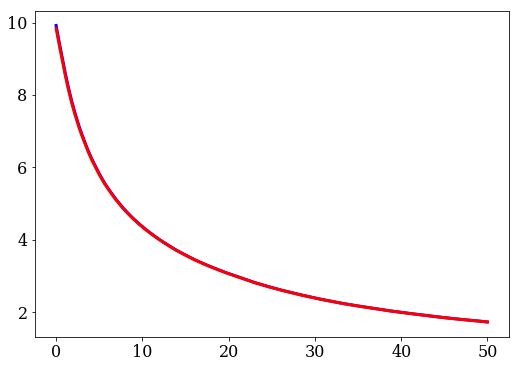

In [81]:
%matplotlib inline

plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(8.5,6))
plt.tight_layout()

plt.plot(t_array/year/1.0e6, F_XUV_array_1, color='b', linewidth=3)
plt.plot(t_array/year/1.0e6, F_XUV_array_2, color='r', linewidth=3)